In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
import matplotlib.pyplot as plt

In [2]:
length_ = 7 # length of each screen
width_ = 7  # width of each screen
dist_ = 1.5 # distance between the screens
h = 0.05 # grid size

In [3]:
corners1 = np.array([ [-0.5*width_, -0.5*length_, 0.5*dist_],
                     [-0.5*width_,  0.5*length_, 0.5*dist_],
                     [0.5*width_,   0.5*length_, 0.5*dist_],
                     [0.5*width_,  -0.5*length_, 0.5*dist_]])
corners2 = np.array([ [-0.5*width_, -0.5*length_, -0.5*dist_],
                     [-0.5*width_,  0.5*length_, -0.5*dist_],
                     [0.5*width_,   0.5*length_, -0.5*dist_],
                     [0.5*width_,  -0.5*length_, -0.5*dist_]])
grid1 = bempp.api.shapes.screen(corners1, h = h)
grid2 = bempp.api.shapes.screen(corners2, h = h)

In [4]:
space1 = bempp.api.function_space(grid1, "P", 1)
space2 = bempp.api.function_space(grid2, "P", 1)

In [5]:
N_wn = 15
lbound_wn = 0
ubound_wn = 20
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)
results = np.empty(N_wn, dtype='float64')

In [6]:
for index, point in enumerate(quad_points):

    wavenumber = -1j * np.log(point)

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space1, space1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space1, space1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space1, space2, space2, wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space2, space2, space2, wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])
    
    n = mat.shape[0]
    Id = np.eye(n)
    inv_mat2 = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat2), Id)

    combined = inv_mat2.dot(mat)
    sign, logdet = slogdet(combined)
    
    results[index] = logdet
    print(f"Log Determinant: {index}: {logdet}")

Log Determinant: 0: 5.393463453629007e-13
Log Determinant: 1: -0.002737477540985894
Log Determinant: 2: -0.017012119369684855
Log Determinant: 3: -0.04786383671183024
Log Determinant: 4: -0.09757667510929373
Log Determinant: 5: -0.16684844677597208
Log Determinant: 6: -0.25531446524382145
Log Determinant: 7: -0.3618420914646793
Log Determinant: 8: -0.48470166238864304
Log Determinant: 9: -0.6216526772073749
Log Determinant: 10: -0.7699585156855585
Log Determinant: 11: -0.9263271932482257
Log Determinant: 12: -1.0867606356624169
Log Determinant: 13: -1.2462781938202354
Log Determinant: 14: -1.3984744452967635


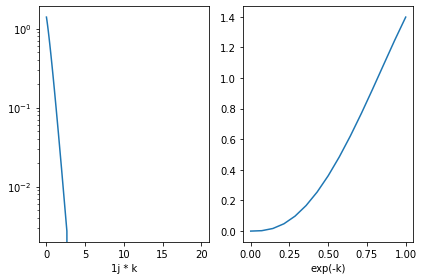

In [7]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = figure()
ax1 = fig.add_subplot(121)
ax1.set_xlabel('1j * k')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('exp(-k)')
ax1.semilogy(-np.log(quad_points), -results)
ax2.plot(quad_points, -results)
fig.tight_layout()

In [8]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print(f"The normalized Casimir Energy is: {casimir_energy}")

area_ = length_ * width_
casimir_energy_unit_area = casimir_energy/area_
print(f"The normalized Casimir Energy per unit area is: {casimir_energy_unit_area}")

The normalized Casimir Energy is: 0.11243356051969162
The normalized Casimir Energy per unit area is: 0.0022945624595855432


The following paper states the Casimir energy between two perfectly conducting plates at a distance $a$ is:

$$\mathcal{E}_{\text{per unit area}}(a) = \frac{1}{2}\frac{\pi^{2}}{720}\frac{1}{a^{3}}$$

https://iopscience.iop.org/article/10.1088/1126-6708/2003/06/018/pdf?casa_token=lsiQlkbo0DQAAAAA:sDu0bRRkVhtihAFr3TrMvPw5yHmJeTAKXwWN59jyzKqZqh0PCE1-QuGkebrkYN13rHwq40nP

In [9]:
ref_ = 0.5 * (np.pi**2) /(720*(dist_**3))
print(casimir_energy_unit_area, ref_)

0.0022945624595855432 0.002030782798578057


In [10]:
err_ = abs(casimir_energy_unit_area - ref_)/ref_
print(err_)

0.12989063192389813


    length * width    distance       grid size     exact                       Approx                        error

      1*1              1.5             0.1    0.002030782798578057      0.002814171205065016           0.38575686530114556
      3*3              1.5             0.1    0.002030782798578057      0.0025375789874001763          0.24955706202405062
      5*5              1.5             0.1    0.002030782798578057      0.0023586152885156143          0.16143158695607612
      10*10            1.5             0.1    0.002030782798578057      0.0022016075259544284          0.08411767496552654
      
      1*1              1.5             0.05   0.002030782798578057      0.0030144312624035443          0.4843691134838411
      3*3              1.5             0.05   0.002030782798578057      0.002594527382902751           0.27759964518087543
      
      3*3              2               0.05   0.0008567364931501178     0.0011623993208522818          0.3567757766198078
